In [1]:
import pandas as pd
from calitp_data_analysis.tables import tbls
from siuba import _, collect, count, filter, show_query
from update_vars import GCS_FILE_PATH


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Additional Transit Performance Metrics #899

Use the newer recommendations which include performance metrics and ridership experience as outlined in the [UCLA Options for the Future of State Funding for Transit Operations in California](https://escholarship.org/uc/item/2zb6z5rm).  Should try and run/describe all outlined.


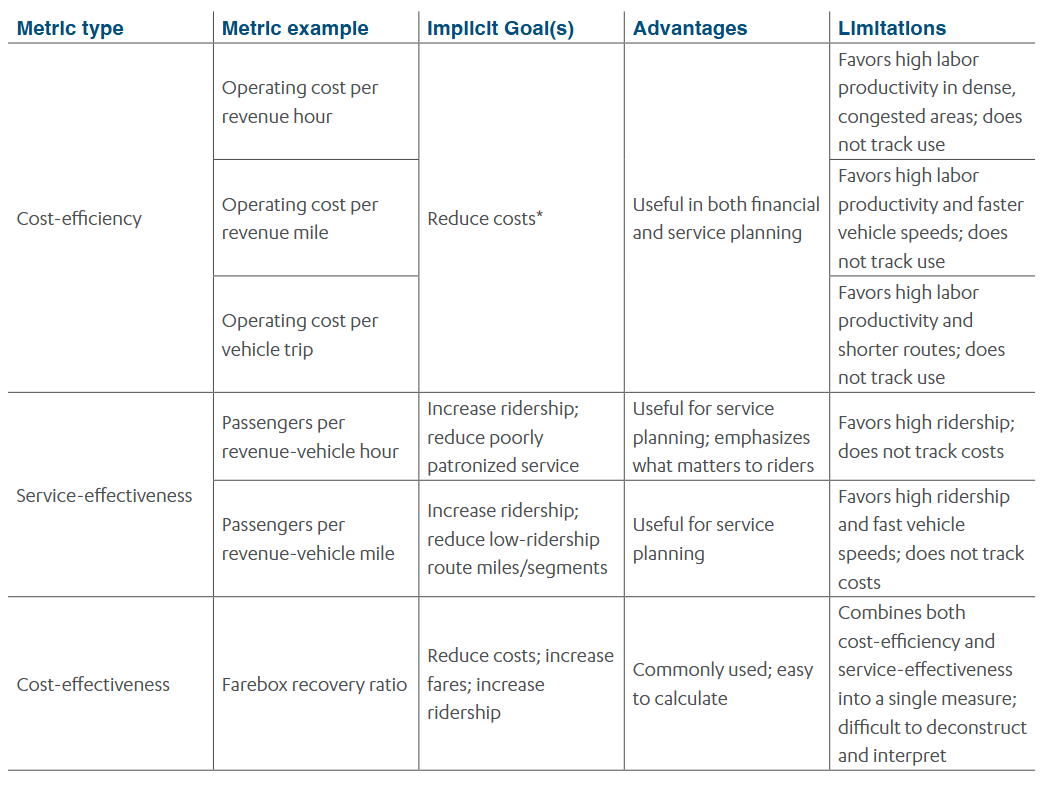

## Data Sources

NTD Products
- [2023 Annual Database Operating Expenses](https://www.transit.dot.gov/ntd/data-product/2023-annual-database-operating-expenses)
    - data url: "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-10/2023%20Operating%20Expenses.xlsx"
- [2022 Annual Database Operating Expenses](https://www.transit.dot.gov/ntd/data-product/2022-annual-database-operating-expenses)
    - data url: "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-04/2022%20Operating%20Expenses.xlsx"

Warehose Tables
- <s>`dim_monthly_ridership_with_adjustments `</s>, but is only for Monthly reporters
- `dim_annual_service_agencies`, has all type of reporters, VRM, VRH, UPT

## Metrics to calculate

Cost-efficiency metrics
- Operating cost per VRH
- Operating cost per VRM
- Operating cost per trip(?)

Service-effectiveness metrics
- Passengers (upt?) per VRH
- Passengers per VRM

---

## Use `dim_annual_service_agencies` to get vrm, upt, vrh, for CA reporters.
- also contains  `2023 operating cost`

In [15]:
# read in dim_annual_service_agencies, filter for reporters in CA for 2023

annnual_service_agencies = (
    tbls.mart_ntd.dim_annual_service_agencies() 
    >> filter(_.state == "CA",
              _.report_year == 2023
             )
    >> collect()
)
annnual_service_agencies.info() # 209 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   key                                             209 non-null    object 
 1   report_year                                     209 non-null    int64  
 2   ntd_id                                          209 non-null    object 
 3   agency                                          209 non-null    object 
 4   reporter_type                                   209 non-null    object 
 5   organization_type                               209 non-null    object 
 6   city                                            208 non-null    object 
 7   state                                           209 non-null    object 
 8   agency_voms                                     209 non-null    float64
 9   primary_uza_code                           

### get `NTD IDs` for CA reporters
- will be used to filter the operating expense report

In [3]:
ca_ntd_ids = annnual_service_agencies["ntd_id"].unique() # unique ntd ID to filter by

display(
    type(ca_ntd_ids),
    len(ca_ntd_ids),
)

numpy.ndarray

209

## get `Operating expense` from NTD data report - `2023 Operating Expense`

In [11]:
# Read in 2023 NTD operating exp data
ntd_2023_opex = "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-10/2023%20Operating%20Expenses.xlsx"

col_dict={'NTD ID':str}

opex_2023 = pd.read_excel(
    ntd_2023_opex, 
    dtype = (col_dict)
)
opex_2023.head() # what is the `total` rows in `operating expense type? is it the the sum of the other categories?
# do i sum `total` with the other categories?

,State NTD ID,NTD ID,Agency Name,Reporter Type,Reporting Module,Mode,TOS,Operating Expense Type,Operators' Salaries and Wages,Operators' Paid Absences,Other Salaries and Wages,Other Paid Absences,Fringe Benefits,Service Costs,Fuel and Lubricants,Tires and Tubes,Other Materials and Supplies,Utilities,Casualty and Liability Costs,Taxes,PT Funds In Report,PT Funds Reported Separately,Miscellaneous Expenses,Reduced Reporting Waiver - Total OE,Total Operating Expenses,Total Operating Expenses (No Funds Reported Separately),ADA Related Expenses
0,NaN,1,King County,Full Reporter,Urban,CB,PT,Facility Maintenance,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1947331.0,0.0,NaN,1947331,0,NaN
1,NaN,1,King County,Full Reporter,Urban,CB,PT,General Administration,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,9157562.0,0.0,NaN,9157562,0,NaN
2,NaN,1,King County,Full Reporter,Urban,CB,PT,Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57079186.0,0.0,0.0,57079186,0,NaN
3,NaN,1,King County,Full Reporter,Urban,CB,PT,Vehicle Maintenance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,12729609.0,0.0,NaN,12729609,0,NaN
4,NaN,1,King County,Full Reporter,Urban,CB,PT,Vehicle Operations,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,33244684.0,0.0,NaN,33244684,0,NaN


- Confirmed with the [data.transportation.gov interface](https://data.transportation.gov/Public-Transit/2022-2023-NTD-Annual-Data-Operating-Expenses-by-Ty/j5uj-anzx/explore/query/SELECT%0A%20%20%60agency%60%2C%0A%20%20%60city%60%2C%0A%20%20%60state%60%2C%0A%20%20%60ntd_id%60%2C%0A%20%20%60organization_type%60%2C%0A%20%20%60reporter_type%60%2C%0A%20%20%60report_year%60%2C%0A%20%20%60uace_code%60%2C%0A%20%20%60uza_name%60%2C%0A%20%20%60primary_uza_population%60%2C%0A%20%20%60agency_voms%60%2C%0A%20%20%60mode%60%2C%0A%20%20%60mode_name%60%2C%0A%20%20%60type_of_service%60%2C%0A%20%20%60mode_voms%60%2C%0A%20%20%60operators_wages%60%2C%0A%20%20%60operators_wages_questionable%60%2C%0A%20%20%60other_salaries_wages%60%2C%0A%20%20%60other_salaries_wages_1%60%2C%0A%20%20%60operator_paid_absences%60%2C%0A%20%20%60operator_paid_absences_1%60%2C%0A%20%20%60other_paid_absences%60%2C%0A%20%20%60other_paid_absences_1%60%2C%0A%20%20%60fringe_benefits%60%2C%0A%20%20%60fringe_benefits_questionable%60%2C%0A%20%20%60services%60%2C%0A%20%20%60services_questionable%60%2C%0A%20%20%60fuel_and_lube%60%2C%0A%20%20%60fuel_and_lube_questionable%60%2C%0A%20%20%60tires%60%2C%0A%20%20%60tires_questionable%60%2C%0A%20%20%60other_materials_supplies%60%2C%0A%20%20%60other_materials_supplies_1%60%2C%0A%20%20%60utilities%60%2C%0A%20%20%60utilities_questionable%60%2C%0A%20%20%60casualty_and_liability%60%2C%0A%20%20%60casualty_and_liability_1%60%2C%0A%20%20%60taxes%60%2C%0A%20%20%60taxes_questionable%60%2C%0A%20%20%60purchased_transportation%60%2C%0A%20%20%60purchased_transportation_1%60%2C%0A%20%20%60miscellaneous%60%2C%0A%20%20%60miscellaneous_questionable%60%2C%0A%20%20%60reduced_reporter_expenses%60%2C%0A%20%20%60reduced_reporter_expenses_1%60%2C%0A%20%20%60total%60%2C%0A%20%20%60total_questionable%60%2C%0A%20%20%60separate_report_amount%60%2C%0A%20%20%60separate_report_amount_1%60%0AWHERE%0A%20%20caseless_one_of%28%60report_year%60%2C%20%222023%22%29%0A%20%20AND%20%28caseless_one_of%28%60state%60%2C%20%22CA%22%29%0A%20%20%20%20%20%20%20%20%20AND%20caseless_one_of%28%0A%20%20%20%20%20%20%20%20%20%20%20%60agency%60%2C%0A%20%20%20%20%20%20%20%20%20%20%20%22Sacramento%20Regional%20Transit%20District%2C%20dba%3A%20Sacramento%20RT%22%0A%20%20%20%20%20%20%20%20%20%29%29/page/filter) to use `total operating expense type = "Total" `

In [14]:
keep_cols = [
    "NTD ID",
    "Agency Name",
    "Reporter Type",
    "Operating Expense Type", 
    "Total Operating Expenses",
    "Total Operating Expenses (No Funds Reported Separately)" 
]

ca_opex_2023 = opex_2023[
    opex_2023["NTD ID"].isin(ca_ntd_ids) # filter for CA reporters
][keep_cols] #1250 rows

ca_opex_2023 = ca_opex_2023[ca_opex_2023["Operating Expense Type"] == "Total"] #426 rows

ca_opex_agg = ca_opex_2023.groupby(["NTD ID","Agency Name"]).agg({ #agg by ntd id and agency
    "Total Operating Expenses":"sum"
}).reset_index() 

display(
    ca_opex_2023["NTD ID"].nunique(),#209, matches unique ntd ids list
    ca_opex_2023.info(), 
    ca_opex_agg["Agency Name"].value_counts().head(),# LA County has multiple NTD IDs?
    ca_opex_agg.head(),
)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 7590 to 9059
Data columns (total 6 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   NTD ID                                                   426 non-null    object
 1   Agency Name                                              426 non-null    object
 2   Reporter Type                                            426 non-null    object
 3   Operating Expense Type                                   426 non-null    object
 4   Total Operating Expenses                                 426 non-null    int64 
 5   Total Operating Expenses (No Funds Reported Separately)  426 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 23.3+ KB


209

None

Los Angeles County                               9
Los Angeles County                               2
San Francisco Bay Area Rapid Transit District    1
City of Rosemead                                 1
City of South Gate                               1
Name: Agency Name, dtype: int64

,NTD ID,Agency Name,Total Operating Expenses
0,90003,San Francisco Bay Area Rapid Transit District,796259977
1,90004,Golden Empire Transit District,36554386
2,90006,Santa Cruz Metropolitan Transit District,48569321
3,90008,City of Santa Monica,80777272
4,90009,San Mateo County Transit District,192548133


## merge `dim_annual_service_agencies` to ca opex report to get operating cost against upt, vrm,vrh.

In [6]:
print(len(annnual_service_agencies))
keep_cols_2 = [
    "key",
    "report_year",
    "ntd_id",
    "agency",
    "reporter_type",
    "organization_type",
    "actual_vehicles_passenger_car_revenue_hours",
    "actual_vehicles_passenger_car_revenue_miles",
    "unlinked_passenger_trips_upt",
    "Total Operating Expenses"
]


ca_service_agency_opex = annnual_service_agencies.merge(
    ca_opex_agg,
    how="inner", 
    left_on="ntd_id", 
    right_on="NTD ID"
)[keep_cols_2]

print(ca_service_agency_opex.info())

209
<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   key                                          209 non-null    object 
 1   report_year                                  209 non-null    int64  
 2   ntd_id                                       209 non-null    object 
 3   agency                                       209 non-null    object 
 4   reporter_type                                209 non-null    object 
 5   organization_type                            209 non-null    object 
 6   actual_vehicles_passenger_car_revenue_hours  209 non-null    float64
 7   actual_vehicles_passenger_car_revenue_miles  209 non-null    float64
 8   unlinked_passenger_trips_upt                 209 non-null    float64
 9   Total Operating Expenses                     209 non-null    int64  
dty

## calculate new performance metrics on `2023 operating expense report`

In [7]:
calc_dict = {
    "opex_per_vrh":("Total Operating Expenses", "actual_vehicles_passenger_car_revenue_hours"),
    "opex_per_vrm":("Total Operating Expenses","actual_vehicles_passenger_car_revenue_miles"),
    "upt_per_vrh":("unlinked_passenger_trips_upt","actual_vehicles_passenger_car_revenue_hours"),
    "upt_per_vrm":("unlinked_passenger_trips_upt","actual_vehicles_passenger_car_revenue_miles")
}

for new_col, (num,dem) in calc_dict.items():
    ca_service_agency_opex[new_col] = ca_service_agency_opex[num]/ca_service_agency_opex[dem]
    
ca_service_agency_opex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 0 to 208
Data columns (total 14 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   key                                          209 non-null    object 
 1   report_year                                  209 non-null    int64  
 2   ntd_id                                       209 non-null    object 
 3   agency                                       209 non-null    object 
 4   reporter_type                                209 non-null    object 
 5   organization_type                            209 non-null    object 
 6   actual_vehicles_passenger_car_revenue_hours  209 non-null    float64
 7   actual_vehicles_passenger_car_revenue_miles  209 non-null    float64
 8   unlinked_passenger_trips_upt                 209 non-null    float64
 9   Total Operating Expenses                     209 non-null    int64  
 10  op

In [8]:
ca_service_agency_opex["reporter_type"].value_counts()

Reduced Reporter    84
Full Reporter       81
Rural Reporter      44
Name: reporter_type, dtype: int64

## summary stats 

In [10]:
ca_service_agency_opex.describe()

,report_year,actual_vehicles_passenger_car_revenue_hours,actual_vehicles_passenger_car_revenue_miles,unlinked_passenger_trips_upt,Total Operating Expenses,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm
count,209.0,2.090000e+02,2.090000e+02,2.090000e+02,2.090000e+02,209.000000,209.000000,209.000000,209.000000
mean,2023.0,1.974787e+05,3.017682e+06,3.997801e+06,4.312910e+07,174.836516,12.429503,8.494772,0.677122
std,0.0,7.133054e+05,1.065322e+07,2.235365e+07,1.849415e+08,205.231393,9.797152,9.121568,0.866322
min,2023.0,1.290000e+02,2.764000e+03,2.390000e+02,2.749800e+04,25.546904,0.540507,0.631068,0.033787
25%,2023.0,6.810000e+03,8.249300e+04,2.823200e+04,9.102330e+05,105.186590,7.488396,3.350196,0.245826
50%,2023.0,2.407500e+04,3.464130e+05,1.255200e+05,2.666173e+06,140.450963,10.492805,5.708326,0.430049
75%,2023.0,9.376300e+04,1.402852e+06,8.388670e+05,1.481102e+07,173.058387,14.605288,10.835946,0.789692
max,2023.0,8.220160e+06,1.094675e+08,2.763024e+08,2.196624e+09,2224.457643,107.340115,81.441915,6.679828


In [16]:
ca_service_agency_opex

,key,report_year,ntd_id,agency,reporter_type,organization_type,actual_vehicles_passenger_car_revenue_hours,actual_vehicles_passenger_car_revenue_miles,unlinked_passenger_trips_upt,Total Operating Expenses,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm
0,2be5f9e9e6240b9fdac7926afcb88c53,2023,91000,Amador Transit,Rural Reporter,Independent Public Agency or Authority of Tran...,12877.0,257208.0,32626.0,1484440,115.278403,5.771360,2.533665,0.126847
1,9d3f7fe24eebf85262cca9d007b98e76,2023,91002,"City of Corcoran, dba: Corcoran Area Transit",Rural Reporter,"City, County or Local Government Unit or Depar...",3691.0,31978.0,25199.0,881668,238.869683,27.571080,6.827147,0.788011
2,f87c5857f32b6a347a176e041ff97cbc,2023,91006,"City of Ridgecrest, dba: Ridgerunner",Rural Reporter,"City, County or Local Government Unit or Depar...",4383.0,63282.0,10326.0,1201880,274.214009,18.992447,2.355921,0.163174
3,7426fe5a16ff43ddcb53609e4429e104,2023,91007,Fresno County Rural Transit Agency,Rural Reporter,Independent Public Agency or Authority of Tran...,59434.0,675312.0,169754.0,7112522,119.670929,10.532201,2.856177,0.251371
4,b1f22b6619acbe9d1556617de2beefe2,2023,91008,"Modoc Transportation Agency, dba: Sage Stage",Rural Reporter,Independent Public Agency or Authority of Tran...,6847.0,110345.0,10721.0,496517,72.515992,4.499678,1.565795,0.097159
5,2900b4e7b420234350551f384f2494e1,2023,91009,San Benito County Local Transportation Authori...,Rural Reporter,Independent Public Agency or Authority of Tran...,24075.0,379756.0,63114.0,2183048,90.676968,5.748554,2.621558,0.166196
6,ade7ab166caec64239351abde215de74,2023,91012,"Mountain Area Regional Transit Authority, dba:...",Rural Reporter,Independent Public Agency or Authority of Tran...,51669.0,741004.0,838867.0,5497605,106.400453,7.419130,16.235402,1.132068
7,6c384914eb073748f604ac47e2fdff1d,2023,91014,"City of Rio Vista, dba: Rio Vista Delta Breeze",Rural Reporter,"City, County or Local Government Unit or Depar...",3538.0,44769.0,4082.0,577872,163.332956,12.907860,1.153759,0.091179
8,00ca3d5fa381c8e00db1a6669c209849,2023,91018,"City of Arcata, dba: Arcata & Mad River Transi...",Rural Reporter,"City, County or Local Government Unit or Depar...",5673.0,76242.0,63140.0,1093730,192.795699,14.345505,11.129914,0.828152
9,a4d85010d8be8b2b973023b4902053ee,2023,91020,"City of Needles, dba: Needles Area Transit",Rural Reporter,"City, County or Local Government Unit or Depar...",3444.0,50757.0,19201.0,442576,128.506388,8.719507,5.575203,0.378293
